In [38]:
# Basic python import
import os
import sys
import yaml
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import seaborn as sns
sns.set_context("talk")
sns.set_style("whitegrid")

# Pytorch
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn

# Our custom module
sys.path.append('../')
import data_processing
import models
from evaluation import *
import submission

In [18]:
model_path = ""

In [19]:
with open('../configs/default_params.yaml') as default_params_file:
      default_params = yaml.safe_load(default_params_file)
params = default_params
params

data_dir = os.path.join('..','data')

DEBUG = False
ORGANS = ['kidney', 'largeintestine', 'lung', 'prostate', 'spleen']
torch.manual_seed(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')

device

device(type='cuda', index=0)

# Create Dataset and Dataloader

In [20]:
from data_processing.utils import get_training_datasets_and_dataloaders

train_dataset, validation_dataset, train_dataloader, validation_dataloader, encoder = get_training_datasets_and_dataloaders(batch_size=params["train"]["batch_size"] ,input_size=512)

# Load model

In [21]:
from models.unet import UNet, VGGBlock, Squeeze_Excite
MODEL = torch.load('../model_save/troistetemodele/save_epoch_100_3_tetes.pt')

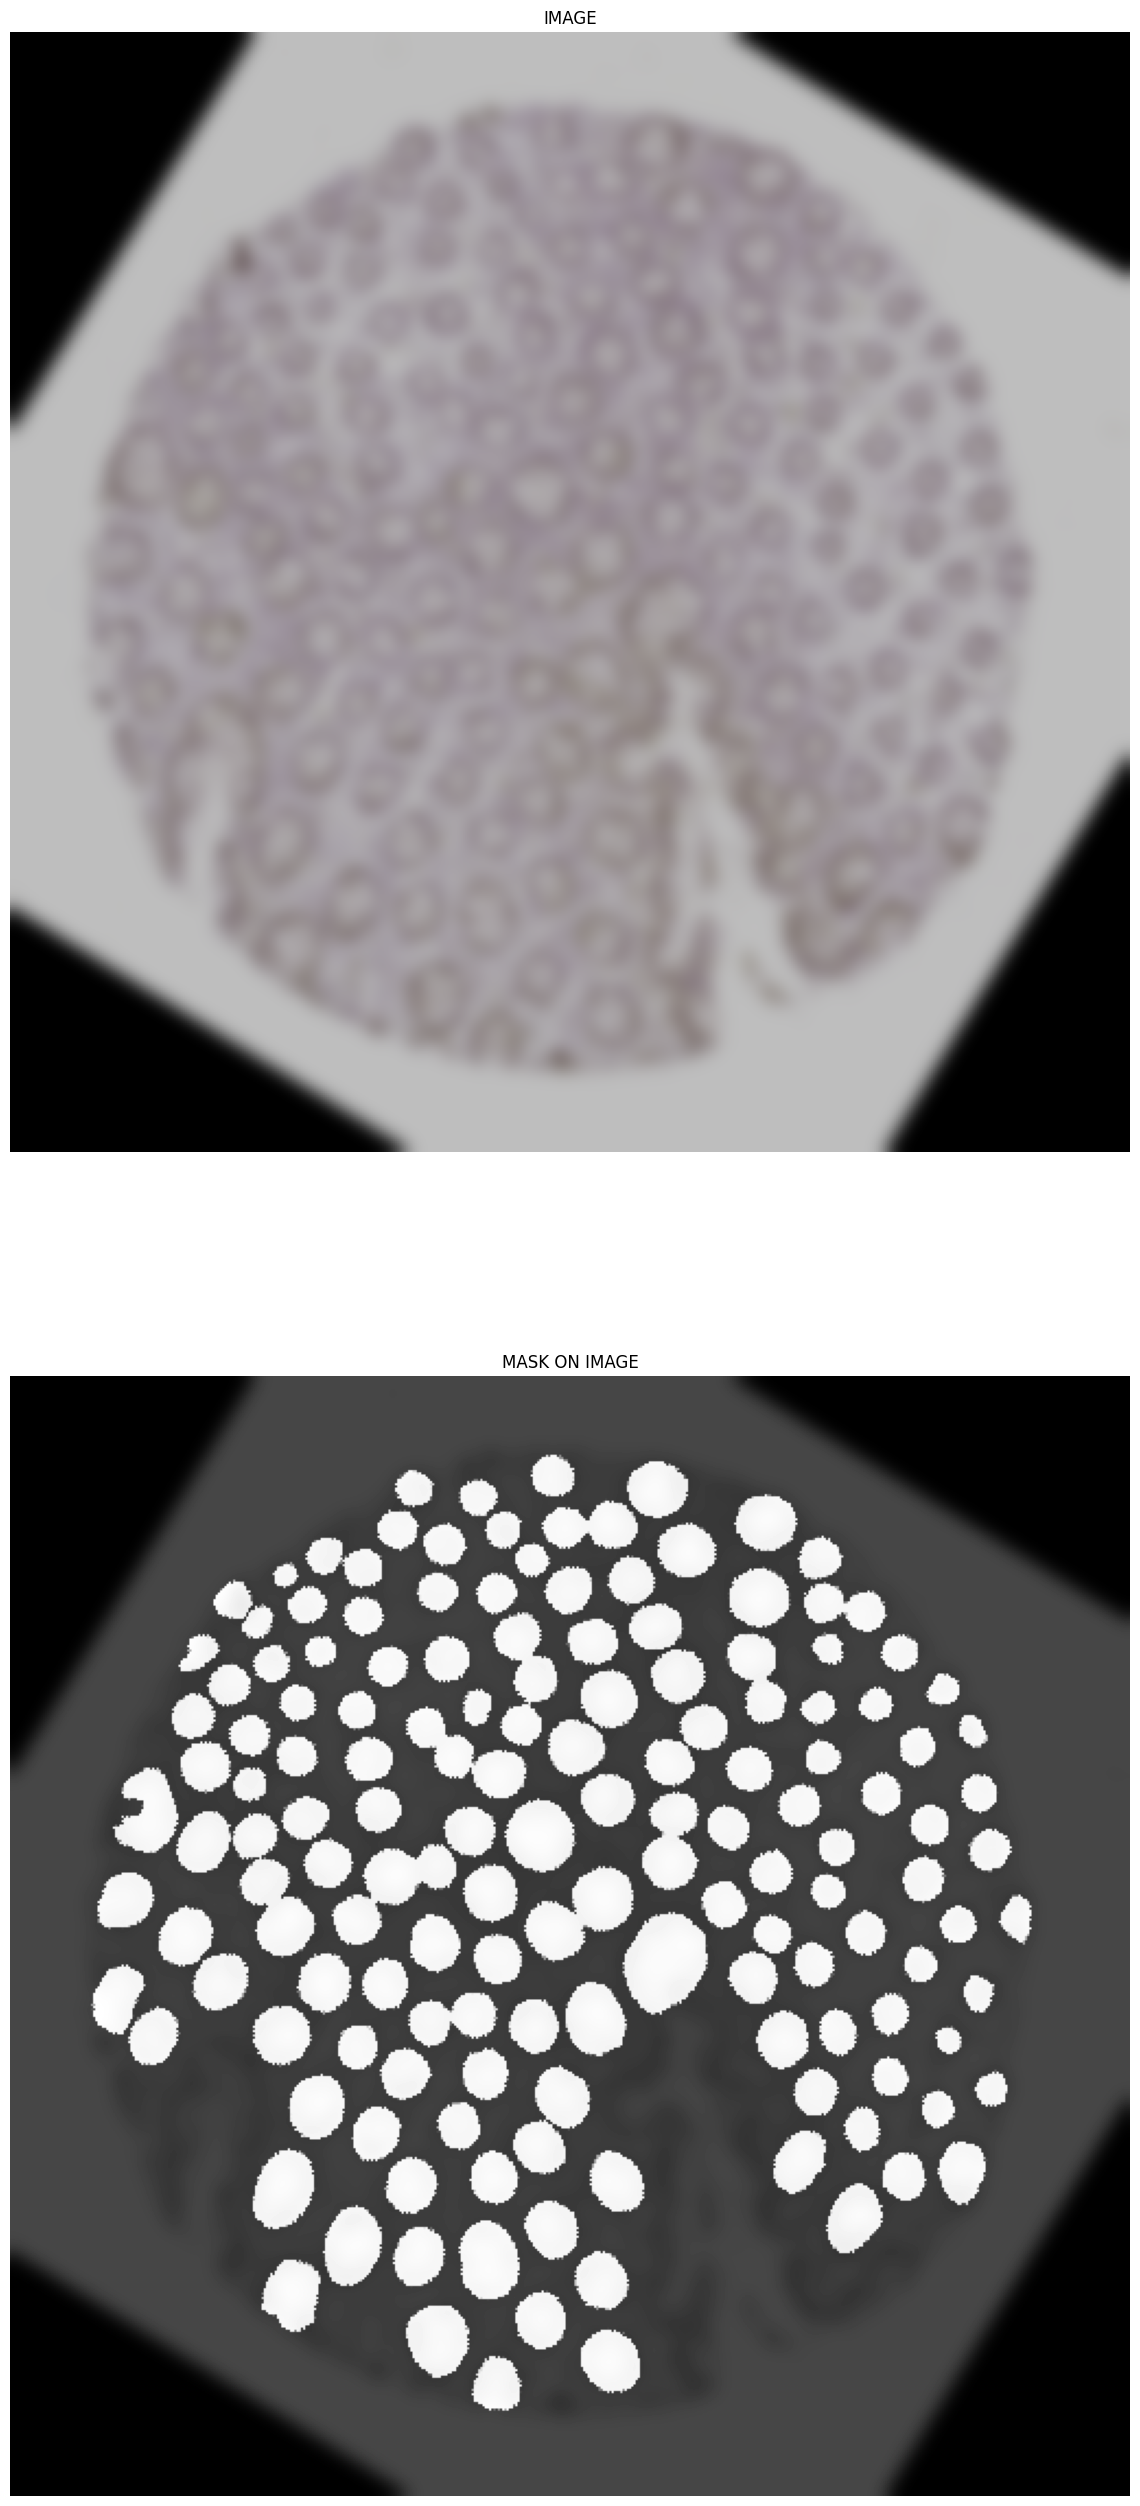

tensor([[-0.4643,  0.4874, -4.0256, -4.7383, -8.5023]])


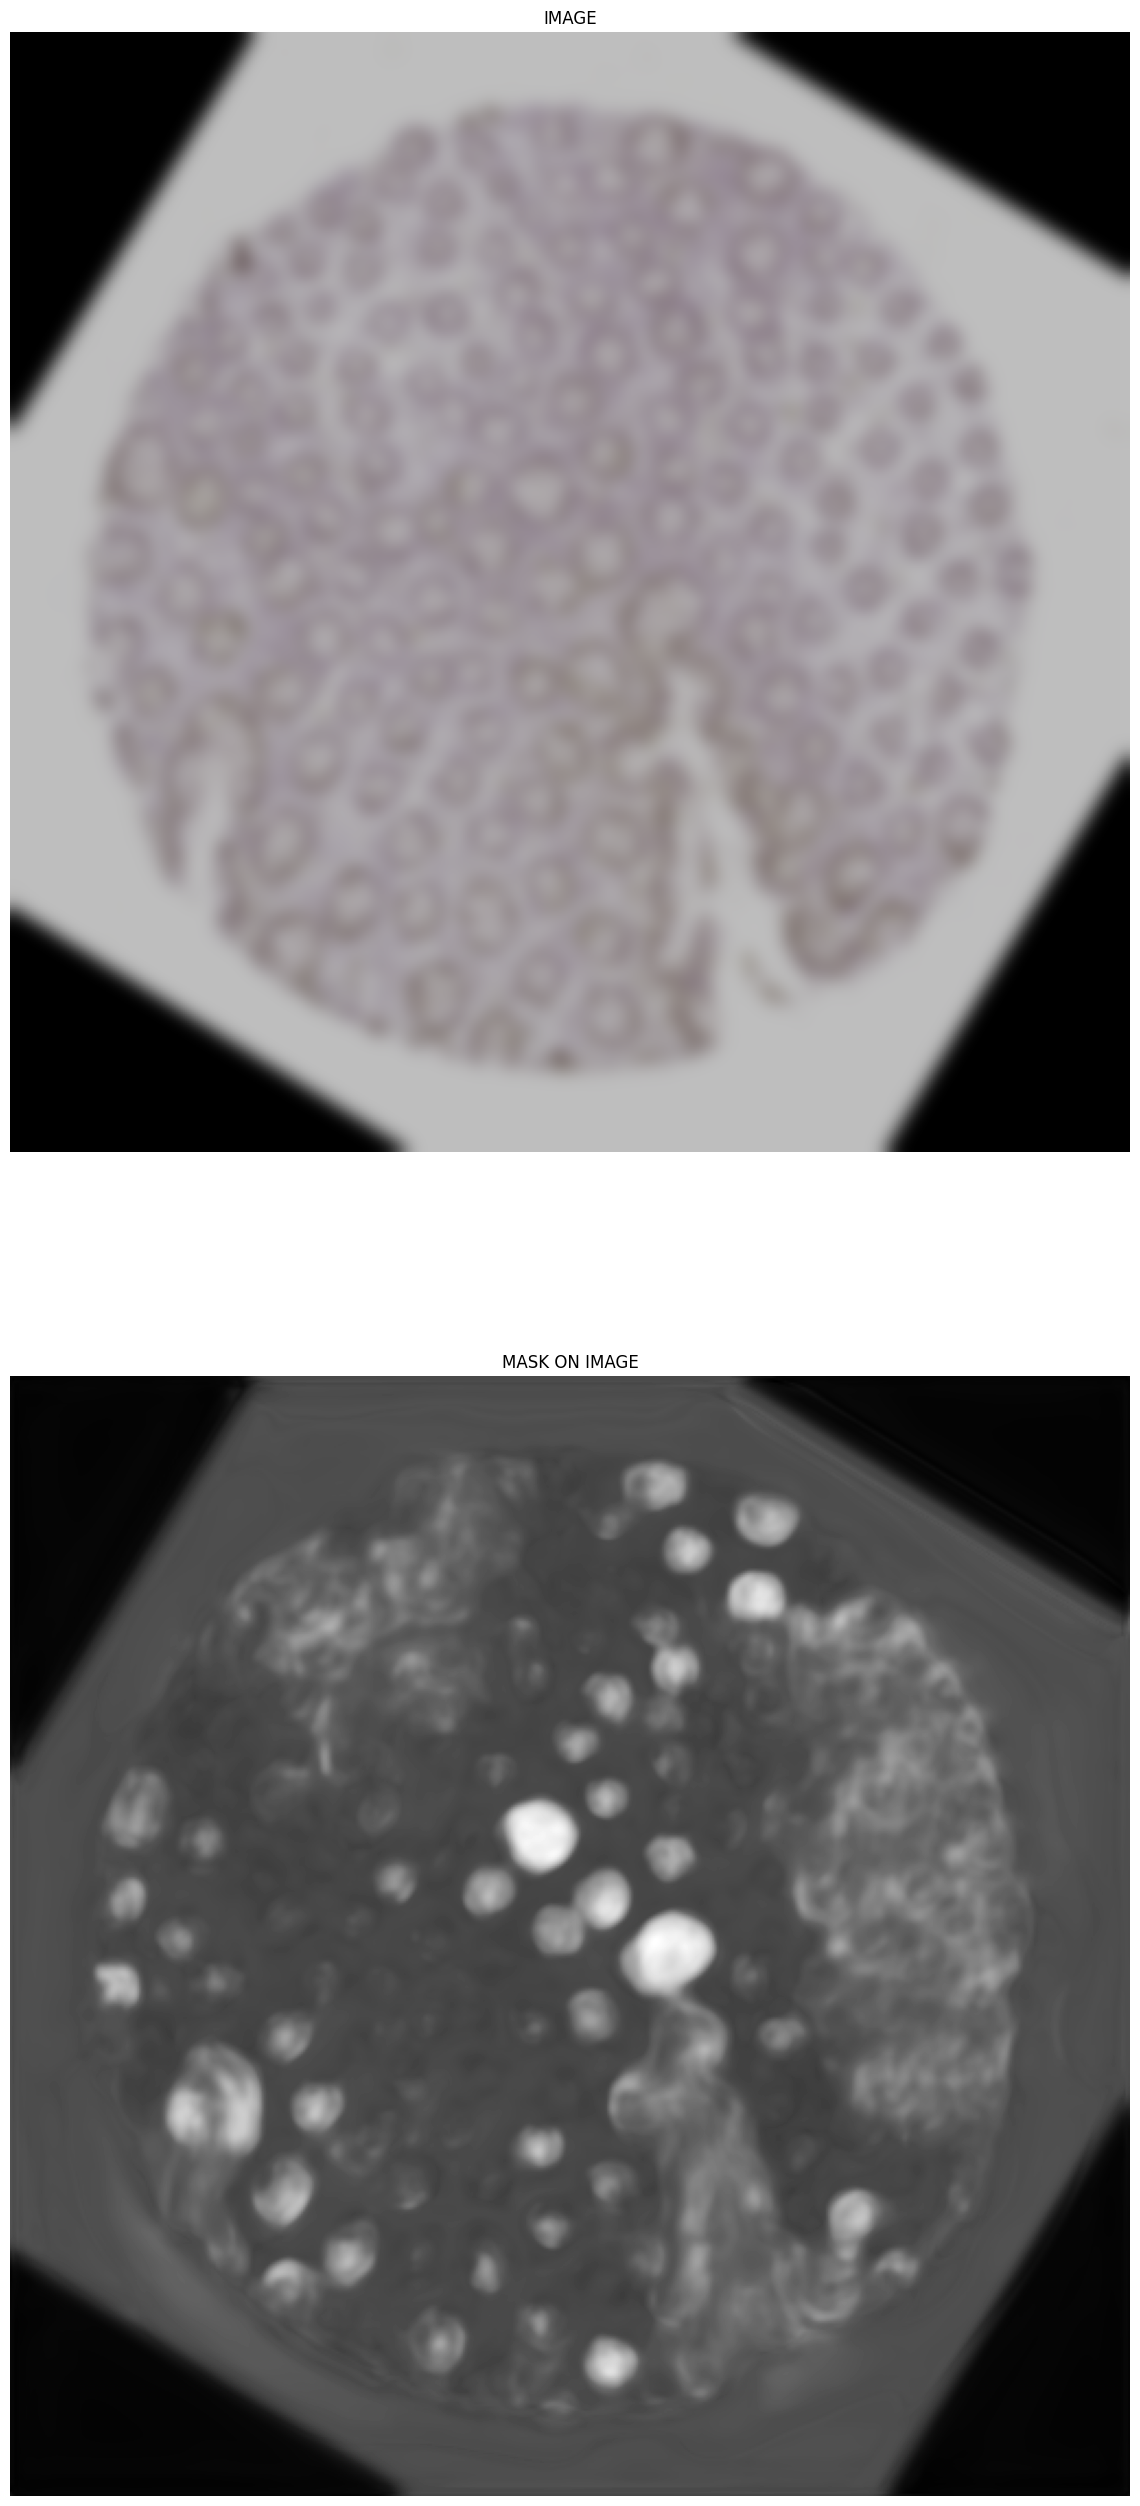

In [22]:
def show_image_and_mask(image,mask,cmaps):
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 32))
    hybr = image[0, :, :]/2 + mask[0, :, :]

    ax[0].imshow(image.T)
    ax[0].axis('off')
    ax[0].set_title('IMAGE')
    ax[1].imshow(hybr.T,cmap=cmaps)
    ax[1].axis('off')
    ax[1].set_title('MASK ON IMAGE')
    plt.show()

image, _, mask, p_size = train_dataset[0]

show_image_and_mask(image,mask,"gray")
y_pred, organ_pred, p_size_pred = MODEL(torch.unsqueeze(image, dim=0).to(device))
y_pred = y_pred.cpu().detach()
organ_pred = organ_pred.cpu().detach()
print(organ_pred)
show_image_and_mask(image,y_pred,"gray")

# Evaluation

Running model on validation dataset

In [33]:
#Validation images, masks and organs
val_preds = {0:{"val_images":[], "val_masks":[], "val_organs":[], "val_p_size":[], "val_y_preds":[], "val_organs_preds":[], "val_p_size_preds":[]}} #Only 1 fold

for l, batch in enumerate(validation_dataset):
    (val_images, val_organs, val_masks, val_p_size) = batch
    val_mask_preds, val_organs_pred, val_p_size_pred = MODEL(torch.unsqueeze(val_images, dim=0).to(device))
    val_mask_preds = val_mask_preds.cpu().detach()
    val_organs_pred = val_organs_pred.cpu().detach()
    val_p_size_pred = float(val_p_size_pred.cpu().detach())
    #print(f'VAL_Y_PREDS shape: {val_mask_preds.shape}, VAL_Y_PREDS dtype: {val_mask_preds.dtype}')
    #print(f'val_images shape: {val_images.shape}, val_masks shape: {val_masks.shape}, val_organs shape: {len(val_organs)}')
    # Cast from Tensorflow to Numpy
    val_preds[0]['val_images'].append(val_images.numpy())
    val_preds[0]['val_masks'].append(val_masks.numpy().astype(np.uint8))
    val_preds[0]['val_organs'].append(encoder.inverse_transform(val_organs.reshape(1, -1))[0][0])
    val_preds[0]['val_p_size'].append(float(val_p_size))
    val_preds[0]['val_y_preds'].append(val_mask_preds[0].numpy())
    val_preds[0]['val_organs_preds'].append(encoder.inverse_transform(val_organs_pred.reshape(1, -1))[0][0])
    val_preds[0]['val_p_size_preds'].append(float(val_p_size_pred))

In [34]:
from evaluation.evaluation import get_y_true_y_pred

# Evaluate IoUs
IoU_Folds = dict()
for fold, v in val_preds.items():
    IoUs, IoUsOrgans = get_y_true_y_pred(v)
    IoU_Folds[fold] = {
        'IoUs': IoUs,
        'IoUsOrgans': IoUsOrgans,
    }

<class 'tqdm.std.tqdm'>


  1%|▏         | 1/70 [00:00<00:13,  4.95it/s]

image shape: (3, 512, 512), y_true shape: (1, 512, 512)
organs: spleen, y_pred shape: (1, 512, 512)


100%|██████████| 70/70 [00:25<00:00,  2.77it/s]


In [39]:
print("Proportion of validation dataset : \n")
for o in ORGANS:
    for fold, v in IoU_Folds.items():
        print(f"{o} : {len(v['IoUsOrgans'][o][0])} pictures ({len(v['IoUsOrgans'][o][0])/len(v['IoUs'][0])})%")

Proportion of validation dataset : 

kidney : 19 pictures (0.2714285714285714)%
largeintestine : 12 pictures (0.17142857142857143)%
lung : 6 pictures (0.08571428571428572)%
prostate : 19 pictures (0.2714285714285714)%
spleen : 14 pictures (0.2)%


# Organ Classification

In [40]:
from tqdm import tqdm
Organ_acc = dict()
count_organ = {}
for organ in ORGANS:
    count_organ[organ] = 0
    Organ_acc[organ] = 0

for fold, v in val_preds.items():
    for idx, organ in enumerate(tqdm(v['val_organs'])):
        count_organ[organ] +=1
        if organ == v['val_organs_preds'][idx]:
            Organ_acc[organ] += 1

for organ in ORGANS:
    if count_organ[organ] != 0 :
        Organ_acc[organ] = Organ_acc[organ]/count_organ[organ]

100%|██████████| 70/70 [00:00<00:00, 70357.36it/s]


<Axes: xlabel='Organ', ylabel='Accuracy'>

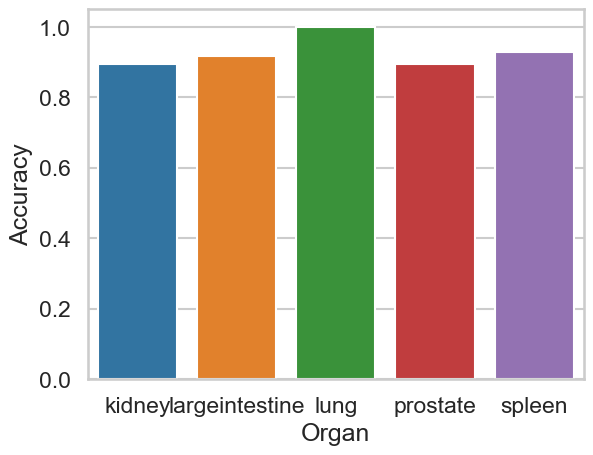

In [41]:
organ_acc_df = pd.DataFrame()
organ_acc_df["Accuracy"] = Organ_acc.values()
organ_acc_df["Organ"] = Organ_acc.keys()
sns.barplot(organ_acc_df, x="Organ", y="Accuracy")

# Segmentation

FOLD 0


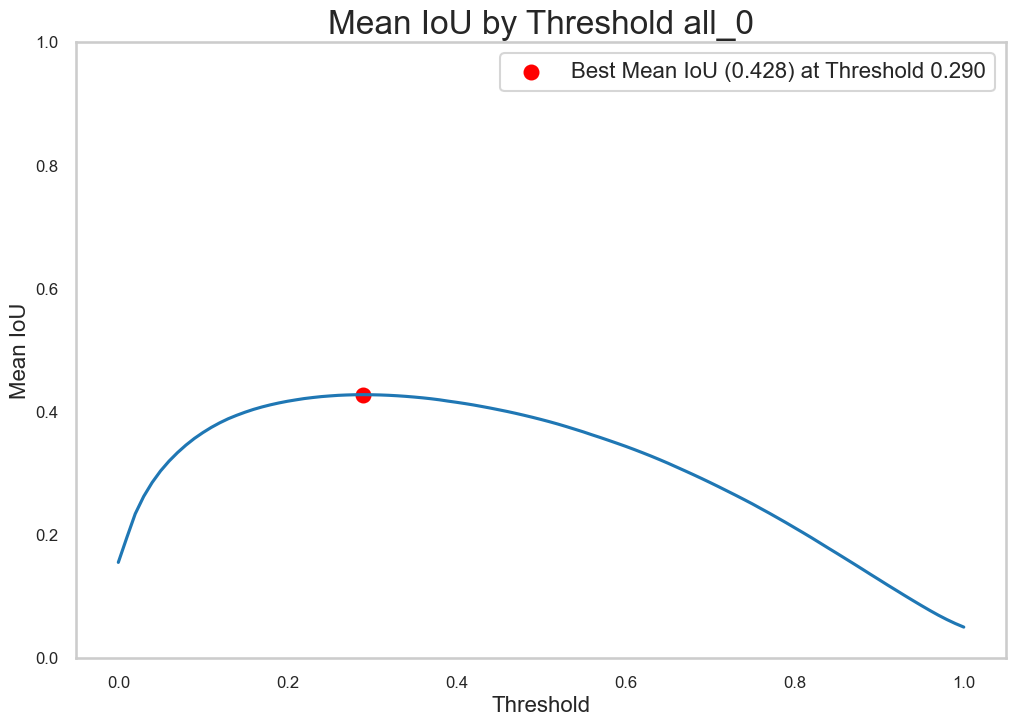

In [47]:
from evaluation.evaluation import plot_iou_by_threshold

# Global Mean Intersection over Union at Threshold
for fold, v in IoU_Folds.items():
    print('=' * 80)
    print(f'FOLD {fold}')
    print('=' * 80)
    v['threshold_best'] = plot_iou_by_threshold(v['IoUs'], f'all_{fold}')

kidney
FOLD 0


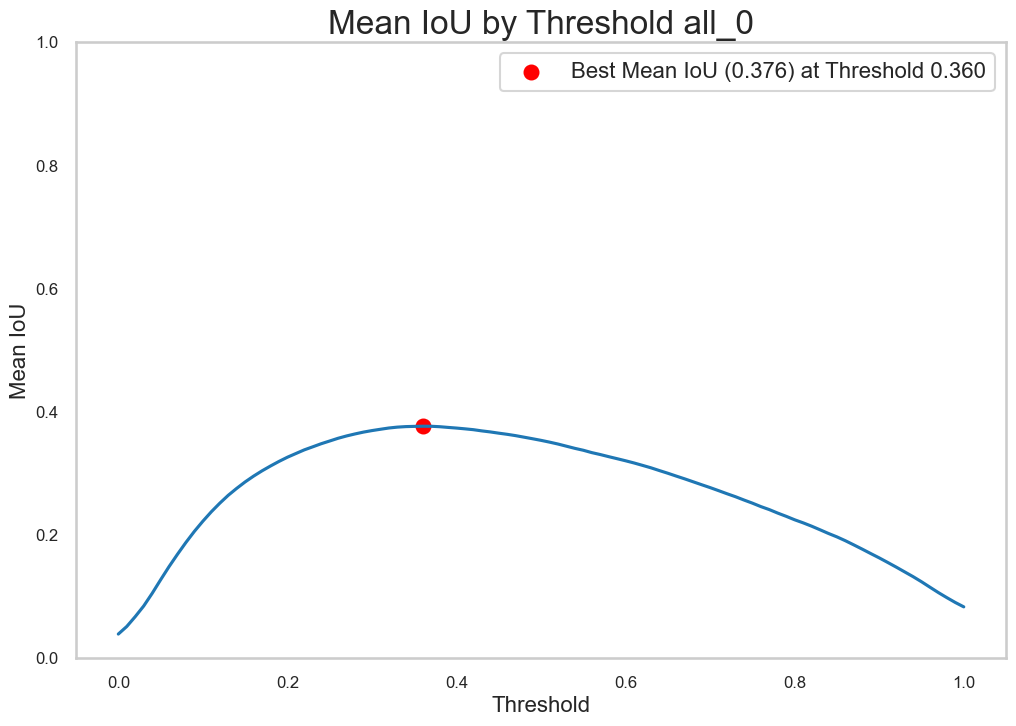

largeintestine
FOLD 0


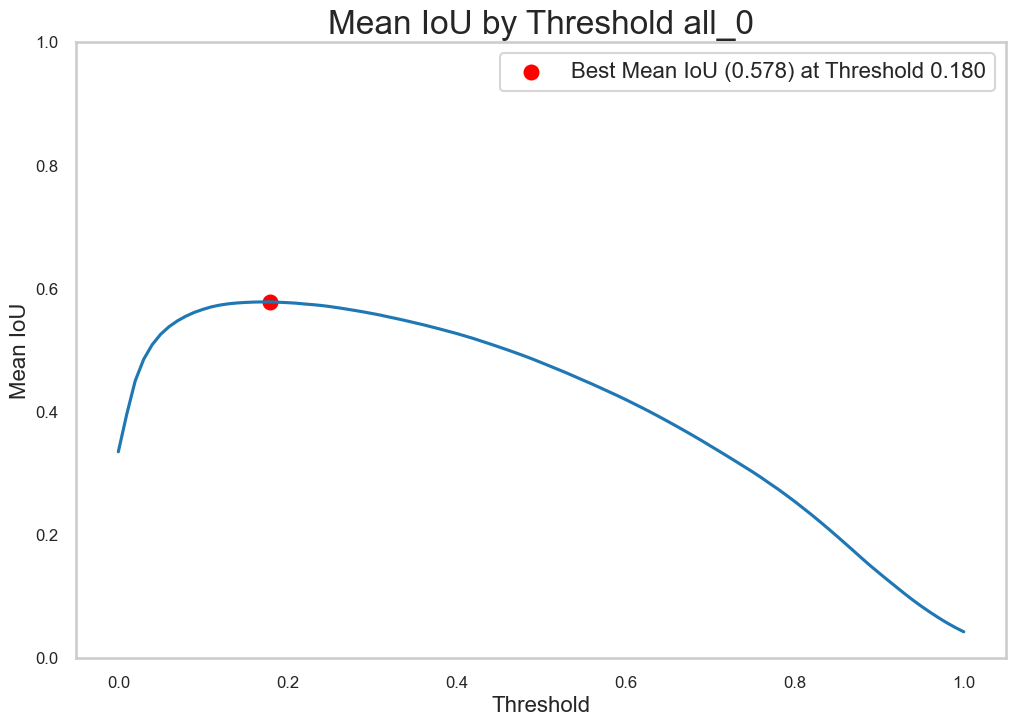

lung
FOLD 0


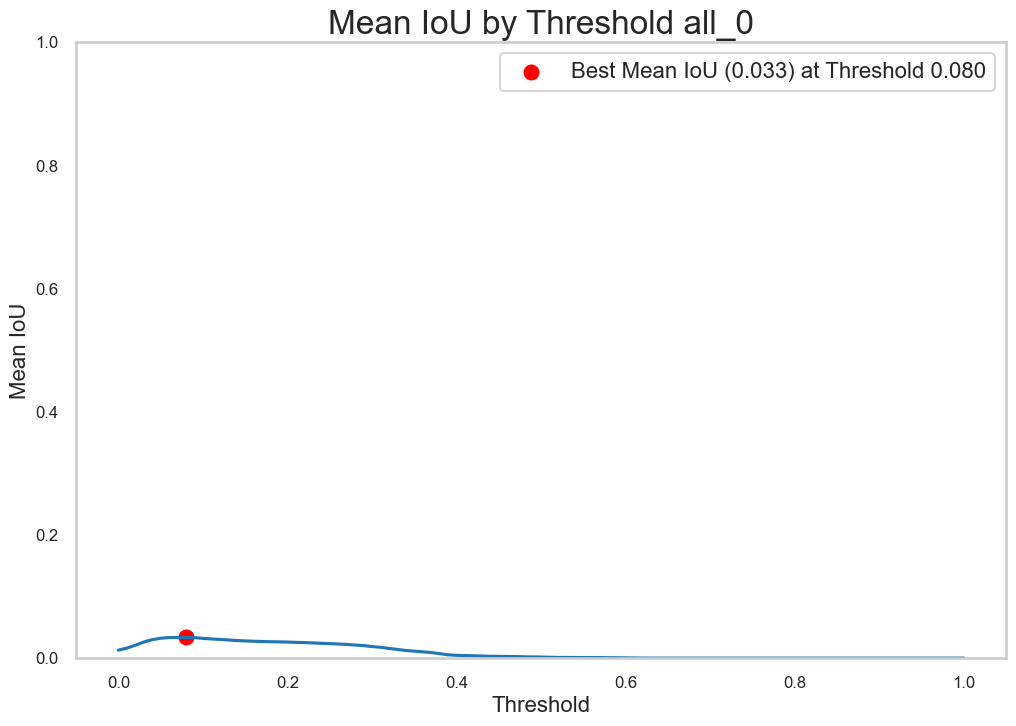

prostate
FOLD 0


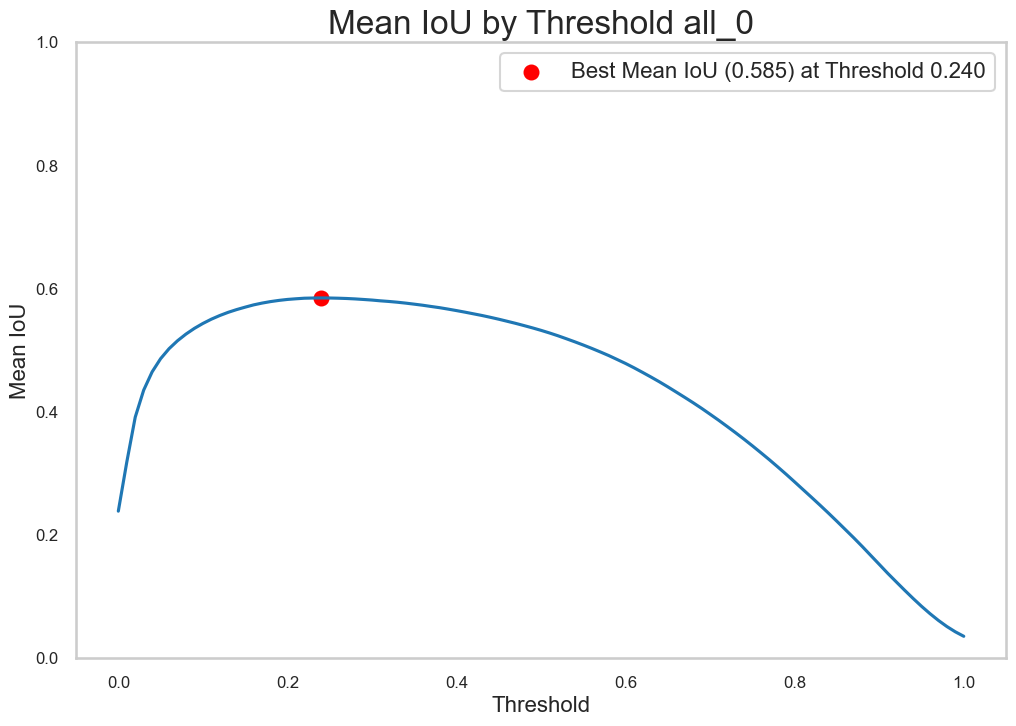

spleen
FOLD 0


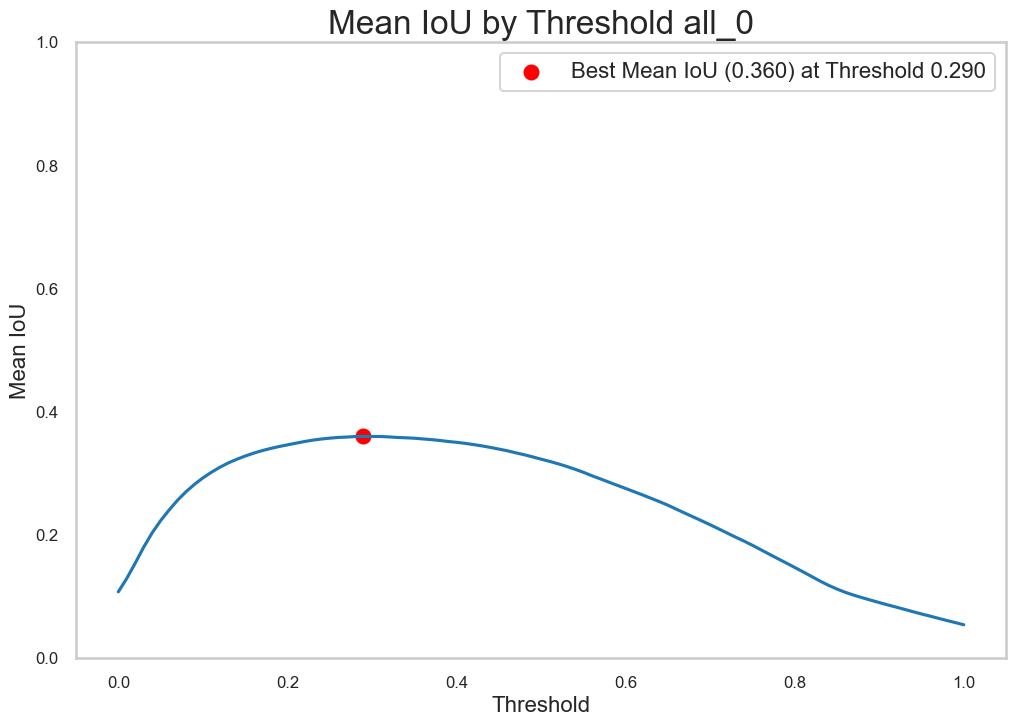

In [48]:
# Global Mean Intersection over Union at Threshold
scores_by_organs = []
for o in ORGANS:
    print(o)
    for fold, v in IoU_Folds.items():
        print('=' * 80)
        print(f'FOLD {fold}')
        print('=' * 80)
        threshold_best = plot_iou_by_threshold(v['IoUsOrgans'][o], f'all_{fold}')
        scores_by_organs.append(np.array(v['IoUsOrgans'][o][threshold_best]).mean())

<Axes: xlabel='Organ', ylabel='Mean IoUs'>

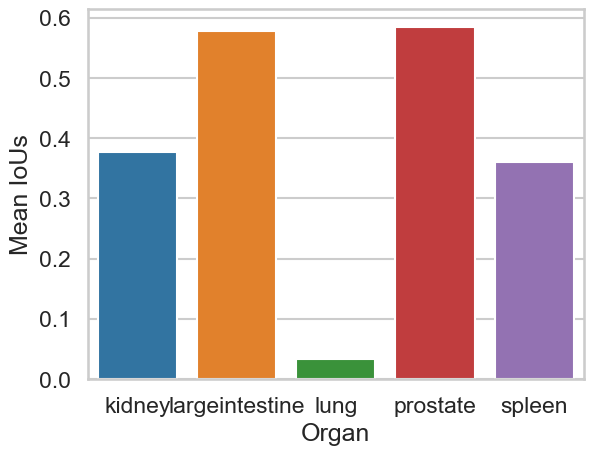

In [49]:
# By organs

organ_iou_df = pd.DataFrame()
organ_iou_df["Mean IoUs"] = scores_by_organs
organ_iou_df["Organ"] = Organ_acc.keys()

sns.barplot(organ_iou_df, x="Organ", y="Mean IoUs")

In [50]:
for fold, v in IoU_Folds.items():
    print('=' * 80)
    print(f'FOLD {fold}')
    print('=' * 80)

    percentiles = [0.01, 0.05, 0.10, 0.25, 0.40, 0.50, 0.60, 0.75, 0.90, 0.95, 0.99]
    s = v['IoUs'][v['threshold_best']]

    display(pd.Series(s).describe(percentiles=percentiles).apply(lambda v: f'{v:.2f}').to_frame(name='Value').T)

FOLD 0


count  mean   std   min    1%    5%   10%   25%   40%   50%   60%  \
Value  70.00  0.43  0.26  0.00  0.00  0.00  0.05  0.20  0.38  0.53  0.57   

        75%   90%   95%   99%   max  
Value  0.64  0.73  0.76  0.80  0.84

FOLD 0


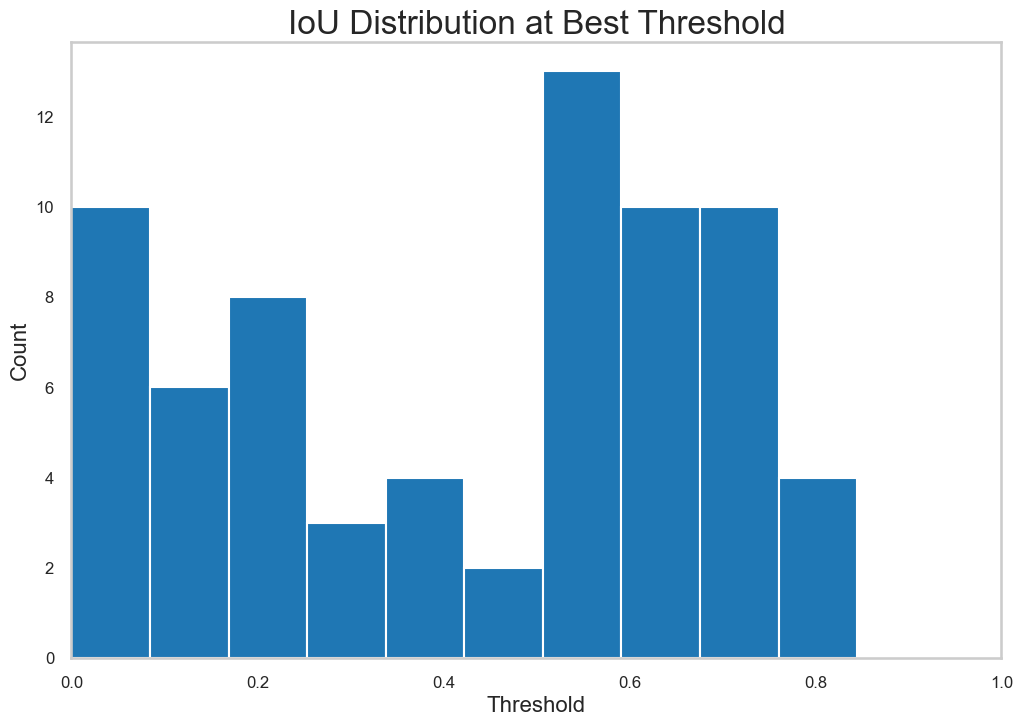

In [51]:
for fold, v in IoU_Folds.items():
    print('=' * 80)
    print(f'FOLD {fold}')
    print('=' * 80)
    plt.figure(figsize=(12,8))
    pd.Series(v['IoUs'][v['threshold_best']]).plot(kind='hist')
    plt.title('IoU Distribution at Best Threshold', size=24)
    plt.grid()
    plt.xlabel('Threshold', size=16)
    plt.ylabel('Count', size=16)
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.xlim(0,1)
    plt.show()

# Pixel Size

In [66]:
p_size_l1_organ = dict()
count_organ = {}
for organ in ORGANS:
    count_organ[organ] = 0
    p_size_l1_organ[organ] = 0

for fold, v in val_preds.items():
    for idx, organ in enumerate(tqdm(v['val_organs'])):
        count_organ[organ] +=1
        p_size_l1_organ[organ] += 1 - (abs(v['val_p_size_preds'][idx] - v['val_p_size'][idx]) / v['val_p_size'][idx])

for organ in ORGANS:
    if count_organ[organ] != 0 :
        p_size_l1_organ[organ] = p_size_l1_organ[organ]/count_organ[organ]

100%|██████████| 70/70 [00:00<00:00, 34965.02it/s]


<Axes: xlabel='Organ', ylabel='Precision'>

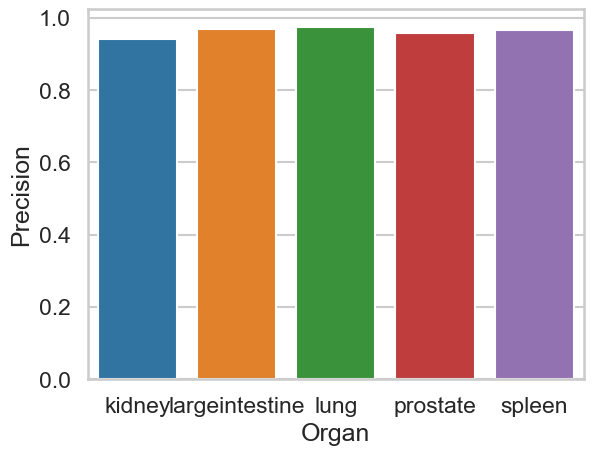

In [67]:
p_size_l1_organ_df = pd.DataFrame()
p_size_l1_organ_df["Precision"] = p_size_l1_organ.values()
p_size_l1_organ_df["Organ"] = p_size_l1_organ.keys()
sns.barplot(p_size_l1_organ_df, x="Organ", y="Precision")

# Summary

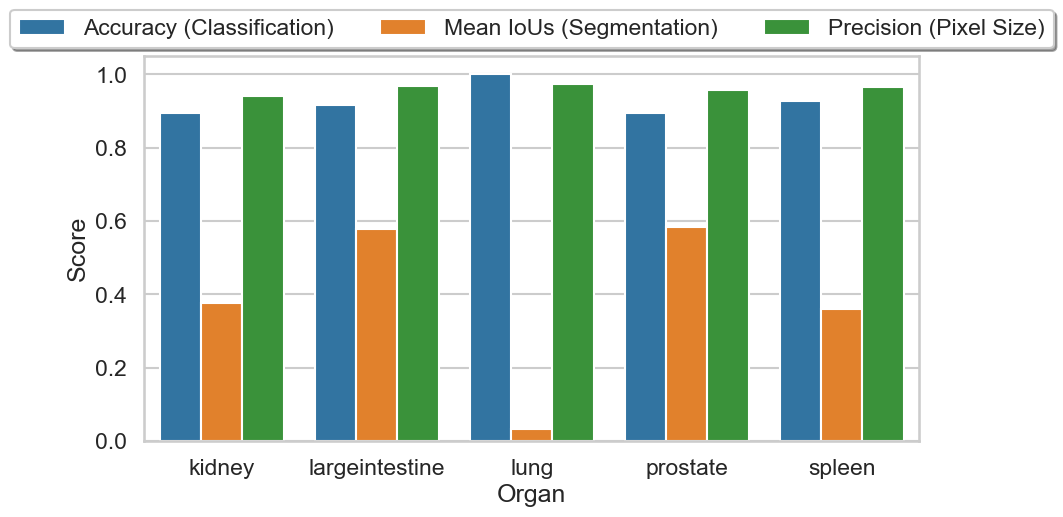

In [73]:
lines = []
for k, o in enumerate(organ_iou_df["Organ"]):
    lines.append([o, "Accuracy (Classification)", list(Organ_acc.values())[k]])
    lines.append([o, "Mean IoUs (Segmentation)", scores_by_organs[k]])
    lines.append([o, "Precision (Pixel Size)", list(p_size_l1_organ.values())[k]])

results_df = pd.DataFrame(lines, columns=["Organ", "Metric", "Score"])
plt.figure(figsize=(10,5))
sns.barplot(results_df, x="Organ", y="Score", hue="Metric")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
          ncol=3, fancybox=True, shadow=True)

# Additional visualization

FOLD 0


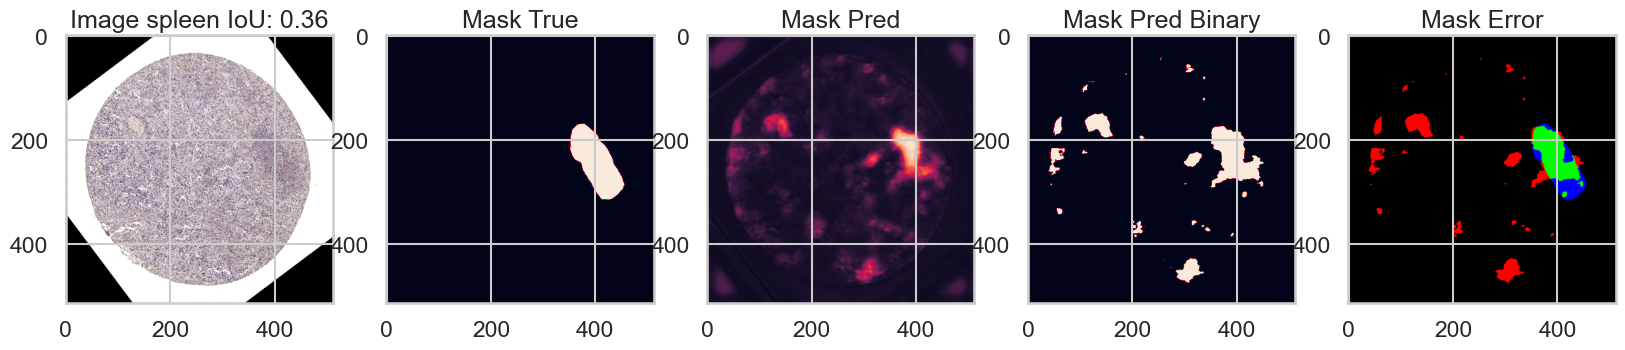

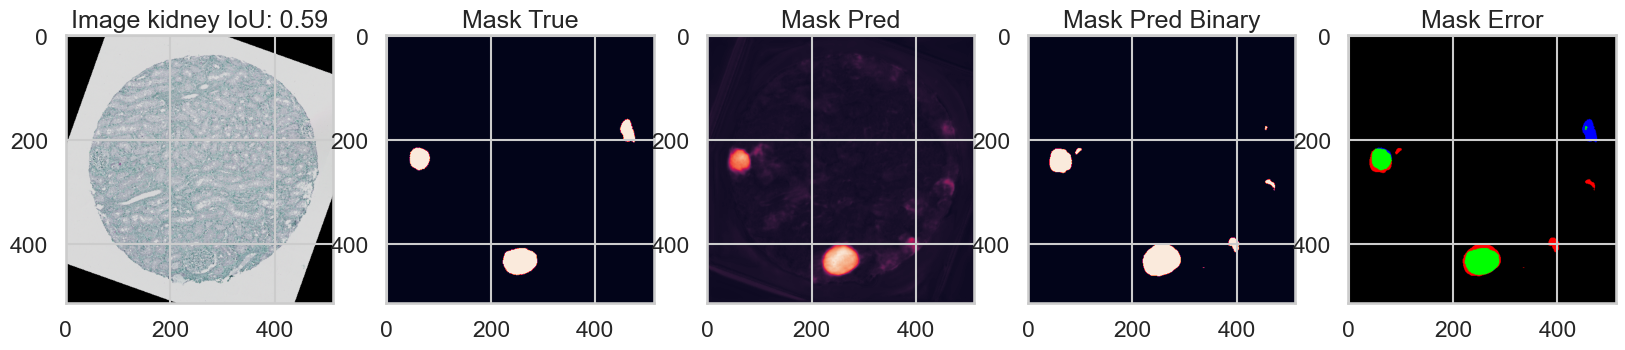

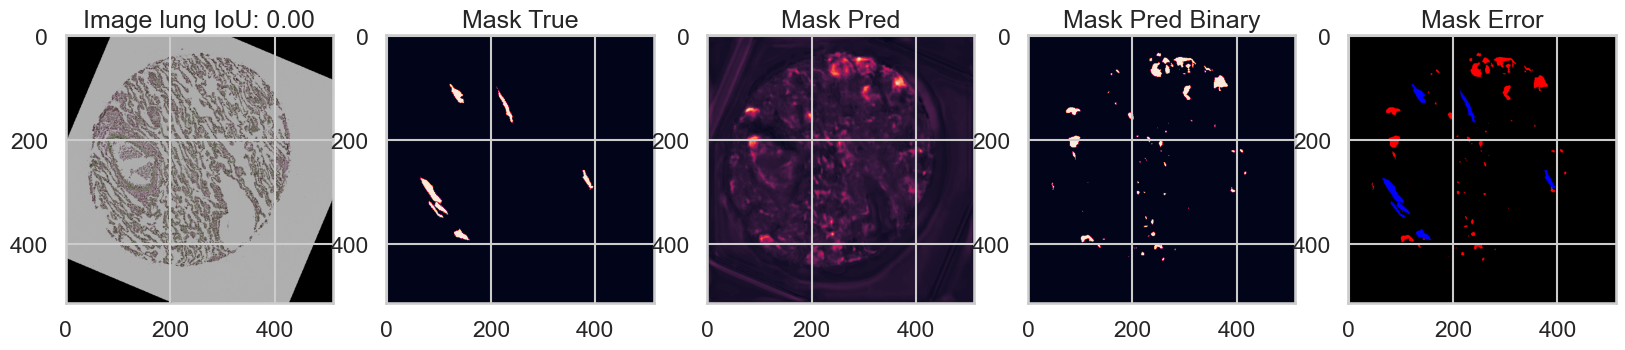

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


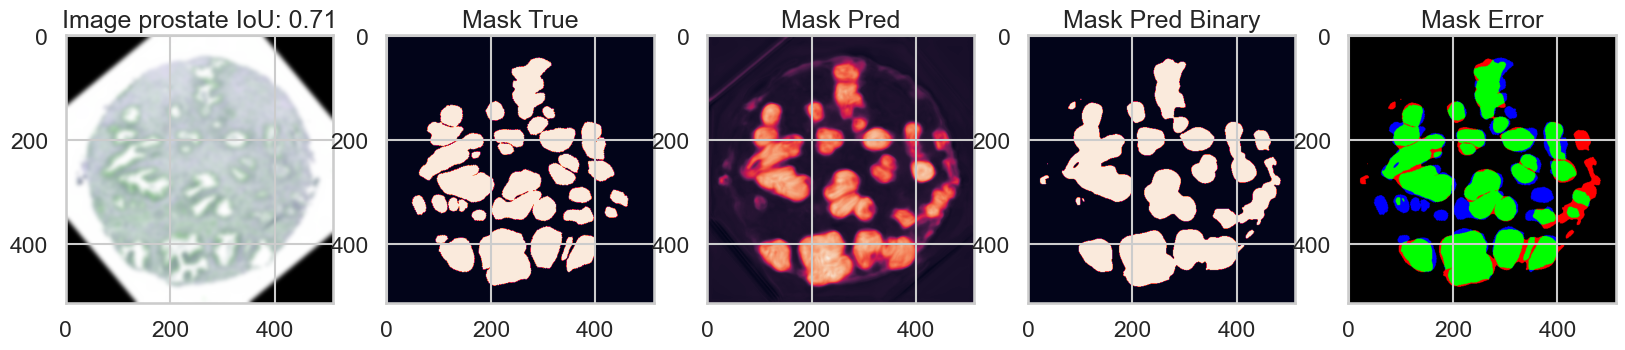

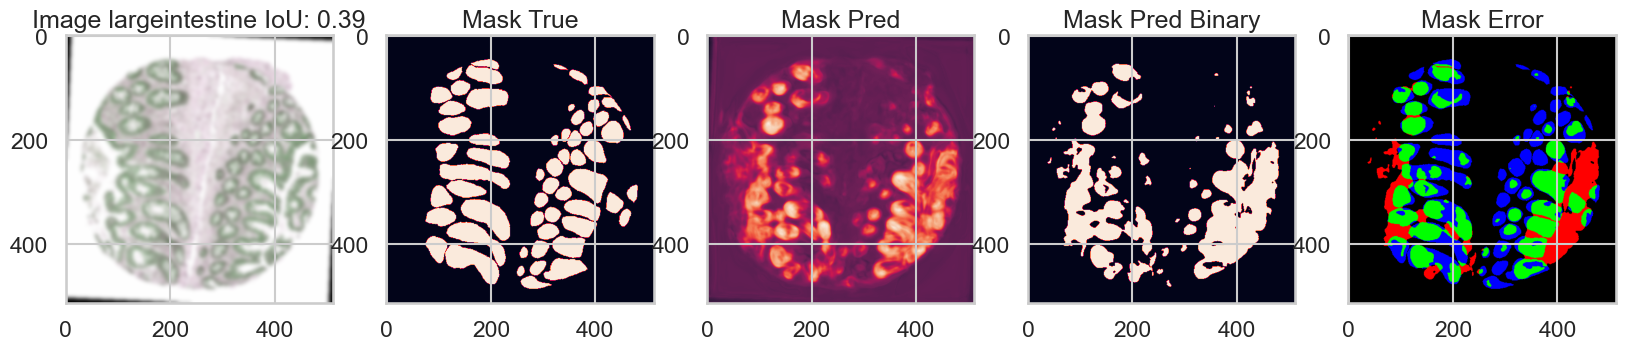

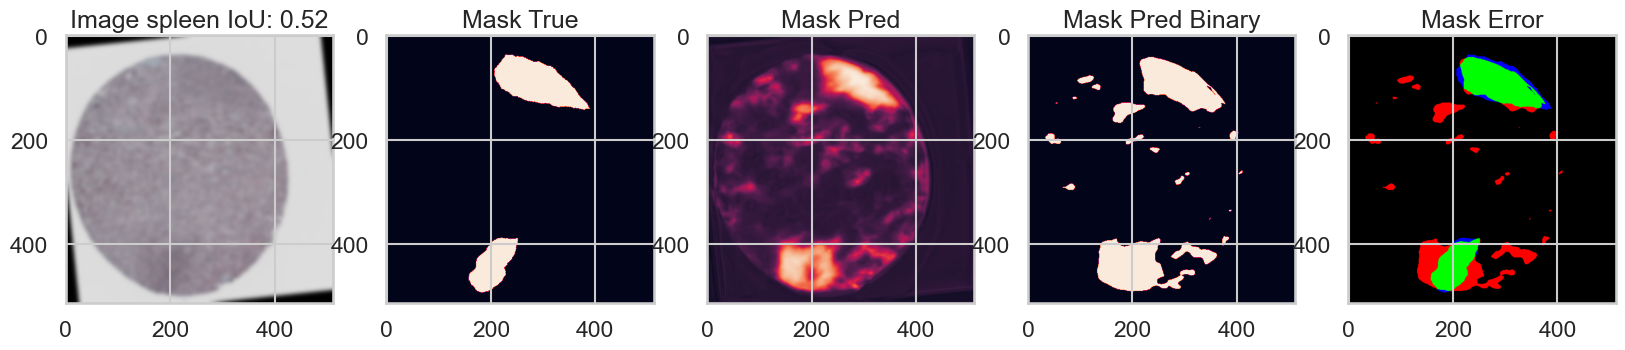

In [69]:
from evaluation.evaluation import plot_validation_predictions

for fold, v in IoU_Folds.items():
    print('=' * 80)
    print(f'FOLD {fold}')
    print('=' * 80)
    threshold_best = IoU_Folds[fold]['threshold_best']
    plot_validation_predictions(val_preds[fold], threshold_best, 6, IoUs)